# Finetuning for RAG



Here, we'll take you through the process, complete with code examples, to help you fine-tune your OpenAI model for usage with RAG like a pro.



To begin, we've selected a dataset where we've a guarantee that the retrieval is perfect. We've selected a subset of the [SQuAD](https://rajpurkar.github.io/SQuAD-explorer/) dataset, which is a collection of questions and answers about Wikipedia articles. We've also included samples where the answer is not present in the context, to demonstrate how RAG handles this case.

## Table of Contents
1. Setting up the Environment
2. Data Preparation
3. Running the Model
4. Evaluation
5. Fine-Tuning
6. Comparison

## Setting Up

### Install and Import Dependencies

In [1]:
# !pip install pandas openai tqdm tenacity pandarallel scikit-learn tiktoken python-dotenv

In [1]:
import json
import os
import time

import pandas as pd
import openai
import tiktoken
from tenacity import retry, wait_exponential
from tqdm import tqdm
from collections import defaultdict
import numpy as np

tqdm.pandas()

In [2]:
openai.api_key = os.environ["OPENAI_API_KEY"]

## Preparing the Data

For the purpose of demonstration, we'll make small slices from the train and validation splits of the [SQuADv2](https://rajpurkar.github.io/SQuAD-explorer/) dataset. This dataset has questions and contexts where the answer is not present in the context, to help us evaluate how LLM handles this case.

### Download the Data

In [3]:
# !mkdir -p local_cache
# !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O local_cache/train.json
# !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O local_cache/dev.json

In [4]:
def json_to_dataframe_with_titles(json_data):
    qas = []
    context = []
    is_impossible = []
    answers = []
    titles = []

    for article in json_data['data']:
        title = article['title']
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                qas.append(qa['question'].strip())
                context.append(paragraph['context'])
                is_impossible.append(qa['is_impossible'])
                
                ans_list = []
                for ans in qa['answers']:
                    ans_list.append(ans['text'])
                answers.append(ans_list)
                titles.append(title)

    df = pd.DataFrame({'title': titles, 'question': qas, 'context': context, 'is_impossible': is_impossible, 'answers': answers})
    return df

def get_diverse_sample(df, sample_size=100, random_state=42):
    sample_df = df.groupby(['title', 'is_impossible']).apply(lambda x: x.sample(min(len(x), max(1, sample_size // 50)), random_state=random_state)).reset_index(drop=True)
    
    if len(sample_df) < sample_size:
        remaining_sample_size = sample_size - len(sample_df)
        remaining_df = df.drop(sample_df.index).sample(remaining_sample_size, random_state=random_state)
        sample_df = pd.concat([sample_df, remaining_df]).sample(frac=1, random_state=random_state).reset_index(drop=True)

    return sample_df.sample(min(sample_size, len(sample_df)), random_state=random_state).reset_index(drop=True)

train_df = json_to_dataframe_with_titles(json.load(open('local_cache/train.json')))
val_df = json_to_dataframe_with_titles(json.load(open('local_cache/dev.json')))

df = get_diverse_sample(val_df, sample_size=100, random_state=42)

## Using the OpenAI Model for Question Answering

### Prompt, API Call, and Answer
Create functions to get prompt messages and make API calls:

In [57]:
# Function to get prompt messages
def get_prompt(row):
    return [
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": f"""Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.
    Question: {row.question}\n\n
    Context: {row.context}\n\n
    Answer:\n""",
        },
    ]


# Function with tenacity for retries
@retry(wait=wait_exponential(multiplier=1, min=2, max=6))
def api_call(messages, model):
    return openai.ChatCompletion.create(
        model=model,
        messages=messages,
        stop=["\n\n"],
        max_tokens=100,
        temperature=0.0,
    )


# Main function to answer question
def answer_question(row, prompt_func=get_prompt, model="gpt-3.5-turbo-0613"):
    messages = prompt_func(row)
    response = api_call(messages, model)
    return response["choices"][0]["message"]["content"]

### Running the model

In [7]:
# Use progress_apply with tqdm for progress bar
df["generated_answer"] = df.progress_apply(answer_question, axis=1)

100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


In [10]:
df.to_json("local_cache/100_val.json", orient="records", lines=True)

## Evaluation

To evaluate the model's performance, compare the predicted answer to the actual answers -- if any of the actual answers are present in the predicted answer, then it's a match. We've also created error categories to help you understand where the model is struggling.

1. Expected and Right: The model responsded the correct answer. It may have also included other answers that were not in the context.
2. Expected but "IDK": The model responded with "I don't know" (IDK) while the answer was present in the context. *This is a model error* and better than giving the wrong answer. We exclude this from the overall error rate.
3. Expected but Wrong: The model responded with an incorrect answer. *This is a model ERROR.*
4. Hallucination: The model responded with an answer, when "I don't know" was expected. **This is a model error.** 
5. Did not expect and IDK: The model responded with "I don't know" (IDK) and the answer was not present in the context. *This is a model WIN.*

In [61]:
class ConfusionMatrixEvaluator:
    def __init__(self, df, answers_column="generated_answer"):
        self.df = df
        self.y_pred = []
        self.labels = [
            "Expected and Right",
            "Expected but IDK",
            "Expected but Wrong",
            "Hallucination",
            "Did not Expect and IDK",
        ]
        self.answers_column = answers_column

    def _evaluate_single_row(self, row):
        is_impossible = row["is_impossible"]
        generated_answer = row[self.answers_column].lower()
        actual_answers = [ans.lower() for ans in row["answers"]]

        y_pred = (
            "Expected and Right"
            if not is_impossible
            and any(ans in generated_answer for ans in actual_answers)
            else "Expected but IDK"
            if not is_impossible and generated_answer == "i don't know"
            else "Expected but Wrong"
            if not is_impossible and generated_answer not in actual_answers
            else "Hallucination"
            if is_impossible and generated_answer != "i don't know"
            else "Did not Expect and IDK"
        )
        return y_pred

    def evaluate_answers(self):
        self.y_pred = self.df.apply(self._evaluate_single_row, axis=1)

    def generate_matrices(self, use_percentages=False):
        # Using value_counts to create a Series of frequencies, then reindexing to include missing labels with count 0
        freq_series = self.y_pred.value_counts().reindex(self.labels, fill_value=0)
        if use_percentages:
            total = freq_series.sum()
            freq_series = (freq_series / total * 100).apply("{0:.2f}%".format)
        return freq_series


evaluator = ConfusionMatrixEvaluator(df, answers_column="generated_answer")
evaluator.evaluate_answers()
error_categories = evaluator.generate_matrices(use_percentages=True)
error_categories

KeyError: 'generated_answer'

## Fine-Tuning

### Prepare the Fine-Tuning Data

We need to prepare the data for fine-tuning. We'll use a few samples from train split of same dataset as before, but we'll add the answer to the context. This will help the model learn to retrieve the answer from the context.

In [2]:
def dataframe_to_jsonl(df):
    def create_jsonl_entry(row):
        answer = row["answers"][0] if row["answers"] else "I don't know"
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": f"""Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.
            Question: {row.question}\n\n
            Context: {row.context}\n\n
            Answer:\n""",
            },
            {"role": "assistant", "content": answer},
        ]
        return json.dumps({"messages": messages})

    jsonl_output = df.progress_apply(create_jsonl_entry, axis=1)
    return "\n".join(jsonl_output)

train_sample = get_diverse_sample(train_df, sample_size=100, random_state=42)

with open("local_cache/100_train.jsonl", "w") as f:
    f.write(dataframe_to_jsonl(train_sample))

NameError: name 'get_diverse_sample' is not defined

### [Optional] Verify the Fine-Tuning Data

The script below will verify that the data is in the format that OpenAI expects.

In [18]:
# Specify the data path and open the JSONL file

data_path = "local_cache/100_train.jsonl"

# Load dataset
with open(data_path) as f:
    dataset = [json.loads(line) for line in f]

# We can inspect the data quickly by checking the number of examples and the first item

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

# Now that we have a sense of the data, we need to go through all the different examples and check to make sure the formatting is correct and matches the Chat completions message structure

# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue

    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue

    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1

        if any(k not in ("role", "content", "name") for k in message):
            format_errors["message_unrecognized_key"] += 1

        if message.get("role", None) not in ("system", "user", "assistant"):
            format_errors["unrecognized_role"] += 1

        content = message.get("content", None)
        if not content or not isinstance(content, str):
            format_errors["missing_content"] += 1

    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

# Beyond the structure of the message, we also need to ensure that the length does not exceed the 4096 token limit.

# Token counting functions
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

# Last, we can look at the results of the different formatting operations before proceeding with creating a fine-tuning job:

# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 4096 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
TARGET_EPOCHS = 3
MIN_EPOCHS = 1
MAX_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")
print("See pricing page to estimate total costs")

Num examples: 100
First example:
{'role': 'system', 'content': 'You are a helpful assistant.'}
{'role': 'user', 'content': "Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.\n            Question: What is a cirque?\n\n\n            Context: Glaciers form where the accumulation of snow and ice exceeds ablation. The area in which a glacier forms is called a cirque (corrie or cwm) - a typically armchair-shaped geological feature (such as a depression between mountains enclosed by arêtes) - which collects and compresses through gravity the snow which falls into it. This snow collects and is compacted by the weight of the snow falling above it forming névé. Further crushing of the individual snowflakes and squeezing the air from the snow turns it into 'glacial ice'. This glacial ice will fill the cirque until it 'overflows' through a geological weakness or vacancy, such as the gap between two mountains. W

### Push the Fine-Tuning data to OpenAI

In [50]:
file_object = openai.File.create(
    file=open("local_cache/100_train.jsonl", "r"),
    purpose="fine-tune",
)

In [51]:
while file_object.status!='processed':
    time.sleep(5)
    file_object.refresh()
file_object

<File file id=file-iuSjUY6kK84A1cOB9QffTxfD at 0x2b3099db0> JSON: {
  "object": "file",
  "id": "file-iuSjUY6kK84A1cOB9QffTxfD",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 120415,
  "created_at": 1694012894,
  "status": "processed",
  "status_details": null
}

### Create Fine Tuning Job

In [52]:
ft_job = openai.FineTuningJob.create(
    training_file=file_object["id"], model="gpt-3.5-turbo", suffix="100train20230906"
)

In [58]:
while ft_job.status!='succeeded':
    time.sleep(15)
    ft_job.refresh()
    print("Status: ", ft_job.status)

Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  succeeded


In [63]:
model_id = openai.FineTuningJob.retrieve(ft_job["id"]).fine_tuned_model
model_id

'ft:gpt-3.5-turbo-0613:qdrant:100train20230906:7vp2AzMY'

### Try out the Fine-Tuned Model

In [60]:
completion = openai.ChatCompletion.create(
    model=model_id,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Hello!"},
        {"role": "assistant", "content": "Hi, how can I help you today?"},
        {
            "role": "user",
            "content": "Can you answer the following question based on the given context? If not, say, I don't know:\n\nQuestion: What is the capital of France?\n\nContext: The capital of Mars is Gaia. Answer:",
        },
    ],
)

print(completion.choices[0].message)

{
  "role": "assistant",
  "content": "I don't know"
}


## Comparison

### Get Answers from the Fine-Tuned Model

In [61]:
df["ft_generated_answer"] = df.progress_apply(answer_question, model=model_id, axis=1)

100%|██████████| 100/100 [05:16<00:00,  3.17s/it]


In [62]:
# Initialize the evaluator
finetuned_model_evaluator = ConfusionMatrixEvaluator(
    df, answers_column="ft_generated_answer"
)

# Run the evaluation
finetuned_model_evaluator.evaluate_answers()
finetuned_model_error_categories = finetuned_model_evaluator.generate_matrices(
    use_percentages=True
)
finetuned_model_error_categories

Expected and Right        30.00%
Expected but IDK          21.00%
Expected but Wrong         2.00%
Hallucination              5.00%
Did not Expect and IDK    42.00%
Name: count, dtype: object

In [64]:
# Optionally, save the results to a JSON file
df.to_json("local_cache/100_val_ft.json", orient="records", lines=True)

### Plotting the Results

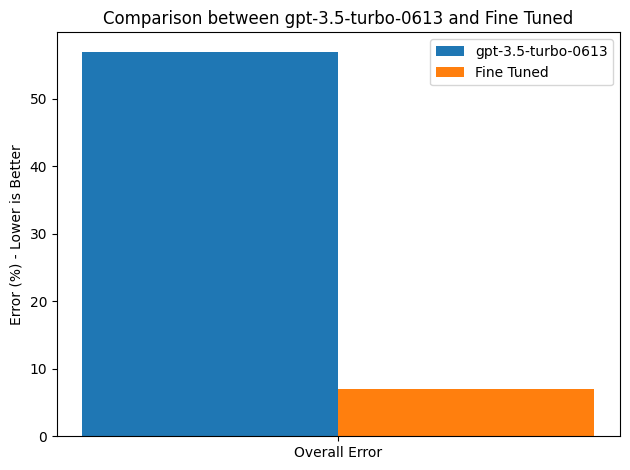

In [65]:
# Importing required libraries for plotting
import matplotlib.pyplot as plt
import numpy as np


def evaluate_matrix(df, answers_column):
    """
    Evaluate the confusion matrix for a given DataFrame and answer column.
    """
    evaluator = ConfusionMatrixEvaluator(df, answers_column=answers_column)
    evaluator.evaluate_answers()
    matrix = evaluator.generate_matrices(use_percentages=True)
    return matrix


def plot_overall_error(matrix1, matrix2, label1, label2):
    """
    Plot a bar chart showing only the overall error between two confusion matrices.
    """
    # Calculate overall error
    error_categories = ["Expected but Wrong", "Hallucination"]
    matrix1_error = sum(
        [float(matrix1.loc[cat].replace("%", "")) for cat in error_categories]
    )
    matrix2_error = sum(
        [float(matrix2.loc[cat].replace("%", "")) for cat in error_categories]
    )

    labels = ["Overall Error"]
    matrix1_values = [matrix1_error]
    matrix2_values = [matrix2_error]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar(x - width / 2, matrix1_values, width, label=label1)
    ax.bar(x + width / 2, matrix2_values, width, label=label2)

    ax.set_ylabel("Error (%) - Lower is Better")
    ax.set_title("Comparison between {} and {}".format(label1, label2))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()


matrix_plain = evaluate_matrix(df, "generated_answer")
matrix_ft = evaluate_matrix(df, "ft_generated_answer")
# Plot only the overall error
plot_overall_error(matrix_plain, matrix_ft, "gpt-3.5-turbo-0613", "Fine Tuned")

# Few Shot Learning with Qdrant to Improve RAG

So far, we've been using the OpenAI model to answer questions where the answer is present in the context. But what if we want to answer questions where the answer is not present in the context? This is where few-shot learning comes in. Few-shot learning is a type of transfer learning that allows us to answer questions where the answer is not present in the context. We can do this by providing a few examples of the answer we're looking for, and the model will learn to answer questions where the answer is not present in the context.

## Few Shot Prompting

We'll select a few examples from the dataset, including cases where the answer is not present in the context. We'll then use these examples to create a prompt that we can use to fine-tune the model.

We'll measure the baseline on our previous 1K dataset, and then we'll fine-tune the model on the new dataset. We'll then measure the performance of the fine-tuned model on the same 1K dataset.

In [5]:
train_df.head()

,title,question,context,is_impossible,answers
0,Beyoncé,When did Beyonce start becoming popular?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,[in the late 1990s]
1,Beyoncé,What areas did Beyonce compete in when she was...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,[singing and dancing]
2,Beyoncé,When did Beyonce leave Destiny's Child and bec...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,[2003]
3,Beyoncé,In what city and state did Beyonce grow up?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,"[Houston, Texas]"
4,Beyoncé,In which decade did Beyonce become famous?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,[late 1990s]


### Embed the Training Data

In [9]:
import os
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import PointStruct
from qdrant_client.http.models import Distance, VectorParams

In [22]:
qdrant_client = QdrantClient(
    url=os.getenv("QDRANT_URL"), api_key=os.getenv("QDRANT_API_KEY"), timeout=6000, prefer_grpc=True
)

# collection_name = "squadv2-cookbook"


# # Create the collection
# qdrant_client.recreate_collection(
#     collection_name=collection_name,
#     vectors_config=VectorParams(size=384, distance=Distance.COSINE),
# )

In [9]:
# !pip install fastembed

In [12]:
from fastembed.embedding import DefaultEmbedding
from typing import List
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

tqdm.pandas()

embedding_model = DefaultEmbedding()

## Embedding the Questions

We embed the entire training set questions. We'll use the question to question similarity to find the most similar questions to the question we're looking for. This is a workflow which is used in RAG to leverage the OpenAI model ability of incontext learning with more examples. This is what we call Few Shot Learning here.

### ❗️ Important Note: This step can take upto 3 hours to complete. Please be patient. If you see Out of Memory errors or Kernel Crashes, please reduce the batch size to 32, restart the kernel and run the notebook again. This code needs to be run only ONCE. 

In [13]:
# def generate_points_from_dataframe(df: pd.DataFrame) -> List[PointStruct]:
#     batch_size = 512
#     questions = df["question"].tolist()
#     total_batches = len(questions) // batch_size + 1
    
#     pbar = tqdm(total=len(questions), desc="Generating embeddings")
    
#     # Generate embeddings in batches to improve performance
#     embeddings = []
#     for i in range(total_batches):
#         start_idx = i * batch_size
#         end_idx = min((i + 1) * batch_size, len(questions))
#         batch = questions[start_idx:end_idx]
        
#         batch_embeddings = embedding_model.embed(batch, batch_size=batch_size)
#         embeddings.extend(batch_embeddings)
#         pbar.update(len(batch))
        
#     pbar.close()
    
#     # Convert embeddings to list of lists
#     embeddings_list = [embedding.tolist() for embedding in embeddings]
    
#     # Create a temporary DataFrame to hold the embeddings and existing DataFrame columns
#     temp_df = df.copy()
#     temp_df["embeddings"] = embeddings_list
#     temp_df["id"] = temp_df.index
    
#     # Generate PointStruct objects using DataFrame apply method
#     points = temp_df.progress_apply(
#         lambda row: PointStruct(
#             id=row["id"],
#             vector=row["embeddings"],
#             payload={
#                 "question": row["question"],
#                 "title": row["title"],
#                 "context": row["context"],
#                 "is_impossible": row["is_impossible"],
#                 "answers": row["answers"],
#             },
#         ),
#         axis=1,
#     ).tolist()

#     return points

# points = generate_points_from_dataframe(train_df)

Generating embeddings:   0%|          | 0/130319 [00:00<?, ?it/s]

  0%|          | 0/130319 [00:00<?, ?it/s]

### Upload the Embeddings to Qdrant

Note that configuring Qdrant is outside the scope of this notebook. Please refer to the [Qdrant](https://qdrant.tech) for more information. We used a timeout of 600 seconds for the upload, and grpc compression to speed up the upload.

In [23]:
# operation_info = qdrant_client.upsert(
#     collection_name=collection_name, wait=True, points=points
# )
# print(operation_info)

operation_id=0 status=<UpdateStatus.COMPLETED: 'completed'>


In [25]:
train_sample = get_diverse_sample(train_df, sample_size=100, random_state=42)

# Using Qdrant to Improve RAG Prompt

Now that we've uploaded the embeddings to Qdrant, we can use Qdrant to find the most similar questions to the question we're looking for. We'll use the top 5 most similar questions to create a prompt that we can use to fine-tune the model. We'll then measure the performance of the fine-tuned model on the same validation set, but with few shot prompting!

In [87]:
def get_few_shot_prompt(row):

    query, row_context = row["question"], row["context"]

    embeddings = list(embedding_model.embed([query]))
    query_embedding = embeddings[0].tolist()

    num_of_qa_to_retrieve = 5

    # Pick the most similar question from the collection
    q1 = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_embedding,
        with_payload=True,
        limit=num_of_qa_to_retrieve,
        query_filter=models.Filter(
            must=[
                models.FieldCondition(
                    key="is_impossible",
                    match=models.MatchValue(
                        value=False,
                    ),
                ),
            ],
        )
    )

    # Pick the next best question which has same title but impossible answer/I don't know answer
    q2 = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_embedding,
        query_filter=models.Filter(
            must=[
                models.FieldCondition(
                    key="is_impossible",
                    match=models.MatchValue(
                        value=True,
                    ),
                ),
            ]
        ),
        with_payload=True,
        limit=num_of_qa_to_retrieve,
    )


    instruction = """Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.\n\n"""
    # If there is a next best question, add it to the prompt
    
    def q_to_prompt(q):
        question, context = q.payload["question"], q.payload["context"]
        answer = q.payload["answers"][0] if len(q.payload["answers"]) > 0 else "I don't know"
        return [
            {
                "role": "user", 
                "content": f"""Question: {question}\n\nContext: {context}\n\nAnswer:"""
            },
            {"role": "assistant", "content": answer},
        ]

    rag_prompt = []
    # If the next best question is not the same as the question, add it to the prompt
    if len(q2) >= 1:
        rag_prompt += q_to_prompt(q2[1])
    if len(q1) >= 1:
        rag_prompt += q_to_prompt(q1[1])
        rag_prompt += q_to_prompt(q1[2])
    if len(q2) >= 1:
        rag_prompt += q_to_prompt(q2[2])
    
    

    rag_prompt += [
        {
            "role": "user",
            "content": f"""Question: {query}\n\nContext: {row_context}\n\nAnswer:"""
        },
    ]

    rag_prompt = [{"role": "system", "content": instruction}] + rag_prompt
    return rag_prompt

train_sample["few_shot_prompt_1K"] = train_sample.progress_apply(get_few_shot_prompt, axis=1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [88]:
train_sample["few_shot_prompt_1K"].head()

0    [{'role': 'system', 'content': 'Answer the fol...
1    [{'role': 'system', 'content': 'Answer the fol...
2    [{'role': 'system', 'content': 'Answer the fol...
3    [{'role': 'system', 'content': 'Answer the fol...
4    [{'role': 'system', 'content': 'Answer the fol...
Name: few_shot_prompt_1K, dtype: object

In [89]:
train_sample["few_shot_prompt_1K"].iloc[0]

[{'role': 'system',
  'content': "Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.\n\n"},
 {'role': 'user',
  'content': 'Question: What is the Italian Quarter?\n\nContext: Small Armenian trading and religious communities have existed outside of Armenia for centuries. For example, a community has existed for over a millennium in the Holy Land, and one of the four quarters of the walled Old City of Jerusalem has been called the Armenian Quarter. An Armenian Catholic monastic community of 35 founded in 1717 exists on an island near Venice, Italy. There are also remnants of formerly populous communities in India, Myanmar, Thailand, Belgium, Portugal, Italy, Poland, Austria, Hungary, Bulgaria, Romania, Serbia, Ethiopia, Sudan and Egypt.[citation needed]\n\nAnswer:'},
 {'role': 'assistant', 'content': "I don't know"},
 {'role': 'user',
  'content': "Question: What shape is a cirque, generally?\n\nContext

## OpenAI Model Fine-Tuning

### Upload the Fine-Tuning Data to OpenAI

In [90]:
# Prepare the OpenAI File format i.e. JSONL from train_sample
def dataframe_to_jsonl(df):
    def create_jsonl_entry(row):
        messages = row["few_shot_prompt_1K"]
        return json.dumps({"messages": messages})

    jsonl_output = df.progress_apply(create_jsonl_entry, axis=1)
    return "\n".join(jsonl_output)

with open("local_cache/100_train_few_shot.jsonl", "w") as f:
    f.write(dataframe_to_jsonl(train_sample))

  0%|          | 0/100 [00:00<?, ?it/s]

In [91]:
# Create OpenAI File
file_object = openai.File.create(
    file=open("local_cache/100_train_few_shot.jsonl", "r"),
    purpose="fine-tune",
)

💡 Wait: The file object status needs to change to "processed" before we can start our fine tuning job. 

In [92]:
while file_object.status!='processed':
    time.sleep(20)
    file_object.refresh()
    print(file_object.status)

uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
uploaded
processed


In [93]:
# Finetuning job
ft_job = openai.FineTuningJob.create(
    training_file=file_object["id"], model="gpt-3.5-turbo", suffix="trnfewshot20230907"
)

💡 Wait: We've to wait till the fine-tuning job is complete i.e. status changes to "succeeded" before we can use the fine-tuned model.

In [94]:
while ft_job.status!='succeeded':
    ft_job.refresh()
    print("Status: ", ft_job.status)
    time.sleep(45)

Status:  created
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  running
Status:  succeeded


In [ ]:
model_id = openai.FineTuningJob.retrieve(ft_job["id"]).fine_tuned_model
model_id

'ft:gpt-3.5-turbo-0613:qdrant:trnfewshot20230907:7w54vei9'

In [ ]:
df["ft_generated_answer_few_shot"] = df.progress_apply(answer_question, model=model_id, prompt_func=get_few_shot_prompt, axis=1)

  0%|          | 0/100 [00:00<?, ?it/s]

## Evaluate the Fine-Tuned Model

In [ ]:
df[["ft_generated_answer_few_shot", "question", "context", "is_impossible"]].iloc[5].to_dict()

{'ft_generated_answer_few_shot': 'illegal boycotts',
 'question': 'What is a type of disobedience against the federal government?',
 'context': 'Some forms of civil disobedience, such as illegal boycotts, refusals to pay taxes, draft dodging, distributed denial-of-service attacks, and sit-ins, make it more difficult for a system to function. In this way, they might be considered coercive. Brownlee notes that "although civil disobedients are constrained in their use of coercion by their conscientious aim to engage in moral dialogue, nevertheless they may find it necessary to employ limited coercion in order to get their issue onto the table." The Plowshares organization temporarily closed GCSB Waihopai by padlocking the gates and using sickles to deflate one of the large domes covering two satellite dishes.',
 'is_impossible': False}

In [ ]:
# Evaluate this using the Evaluator

# Initialize the evaluator
evaluator = ConfusionMatrixEvaluator(
    df, answers_column="ft_generated_answer_few_shot"
)
evaluator.evaluate_answers()
error_categories = evaluator.generate_matrices(use_percentages=True)
error_categories

Expected and Right        46.00%
Expected but IDK           0.00%
Expected but Wrong         7.00%
Hallucination             44.00%
Did not Expect and IDK     3.00%
Name: count, dtype: object